# Recommender System — Full Standalone Notebook

This notebook is a self-contained project deliverable for the course INFO345. It demonstrates:

- Data preparation & EDA
- Item–item collaborative filtering (CF)
- User–user collaborative filtering (UBCF)
- Tag-based content-based filtering (CBF)
- Implicit ALS (matrix factorization) using `implicit`
- Evaluation using Precision@K and Recall@K

All data files are expected under `./data/` relative to this notebook:
- `./data/steam_reviews_trimmed.csv` (preprocessed interaction file)
- `./data/steamspy_tag_data.csv` (tag metadata)

The code style follows the source repo: simple functions, clear variable names, and explicit steps. The notebook is intentionally explanatory and uses only techniques from the course material.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

np.random.seed(42)

DATA_PATH = '../data/steam_reviews_trimmed.csv'
TAG_PATH = '../data/steamspy_tag_data.csv'

print('DATA_PATH =', DATA_PATH)
print('TAG_PATH =', TAG_PATH)

DATA_PATH = ../data/steam_reviews_trimmed.csv
TAG_PATH = ../data/steamspy_tag_data.csv


In [2]:
assert os.path.exists(DATA_PATH), f"Dataset not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
df['rating'] = df['recommended'].astype(int)

print('Rows:', len(df))
df.head()


Rows: 1670727


,app_id,app_name,recommended,author.steamid,rating
0,292030,The Witcher 3: Wild Hunt,True,76561198020027165,1
1,292030,The Witcher 3: Wild Hunt,True,76561198316530785,1
2,292030,The Witcher 3: Wild Hunt,True,76561198246626952,1
3,292030,The Witcher 3: Wild Hunt,True,76561198220195440,1
4,292030,The Witcher 3: Wild Hunt,True,76561198983515611,1


In [3]:
print('Unique users:', df['author.steamid'].nunique())
print('Unique items:', df['app_id'].nunique())
print('Positive (recommended) fraction:', df['rating'].mean())

print("\nTop 10 games by #reviews:")
print(df['app_name'].value_counts().head(10))

Unique users: 117263
Unique items: 313
Positive (recommended) fraction: 0.85504274486496

Top 10 games by #reviews:
app_name
Grand Theft Auto V                44825
PLAYERUNKNOWN'S BATTLEGROUNDS     38515
Tom Clancy's Rainbow Six Siege    36383
The Witcher 3: Wild Hunt          34870
PAYDAY 2                          31781
Garry's Mod                       30468
Terraria                          28807
Fallout 4                         27726
DARK SOULS™ III                   23653
The Elder Scrolls V: Skyrim       23110
Name: count, dtype: int64


In [4]:
ratings = df.rename(columns={'author.steamid': 'user_id','app_id': 'item_id'})[['user_id','item_id','rating']]

train_df, test_df = train_test_split(ratings, test_size=0.1, random_state=42)

print('Train size:', len(train_df))
print('Test size:', len(test_df))

Train size: 1503654
Test size: 167073


In [5]:
train_matrix = train_df.pivot_table(
    index='user_id',
    columns='item_id',
    values='rating',
    aggfunc='mean'
).fillna(0)

item_matrix_train = train_matrix.T

item_sim_matrix_train = cosine_similarity(item_matrix_train)

item_sim_train = pd.DataFrame(
    item_sim_matrix_train,
    index=item_matrix_train.index,
    columns=item_matrix_train.index
)

print('train_matrix shape:', train_matrix.shape)
print('item_sim_train shape:', item_sim_train.shape)

train_matrix shape: (117263, 313)
item_sim_train shape: (313, 313)


In [6]:
all_items = list(train_matrix.columns)
import numpy as np

def recommend_for_user(user_id, top_k=10):
    if user_id not in train_matrix.index:
        return []

    user_ratings = train_matrix.loc[user_id]
    liked_items = user_ratings[user_ratings > 0].index.tolist()

    if len(liked_items) == 0:
        return []

    scores = np.zeros(len(item_sim_train))

    for item in liked_items:
        scores += item_sim_train.loc[item].values

    recommended_indices = np.argsort(scores)[::-1]
    recommended_items = item_sim_train.index[recommended_indices]

    recommended_items = [i for i in recommended_items if i not in liked_items]

    return recommended_items[:top_k]


sample_user = train_matrix.index[0]
print('Sample user:', sample_user)
print('CF recs:', recommend_for_user(sample_user, 5))

Sample user: 76561197960269230
CF recs: [620, 271590, 4000, 379720, 105600]


In [7]:
positive_train = train_df[train_df['rating'] == 1]
item_popularity = positive_train['item_id'].value_counts()
popular_items_global = list(item_popularity.index)

import random

def recommend_popular_for_user(user_id, top_k=10):
    return popular_items_global[:top_k]

def recommend_random_for_user(user_id, top_k=10):
    if len(all_items) <= top_k:
        return all_items
    return list(np.random.choice(all_items, size=top_k, replace=False))

print('Popular recs:', recommend_popular_for_user(sample_user, 5))

Popular recs: [292030, 271590, 359550, 4000, 105600]


In [8]:
def precision_at_k(recommended, actual, k):
    if len(actual) == 0:
        return np.nan
    hits = len(set(recommended[:k]) & set(actual))
    return hits / k

def precision_at_k_user_cf(user_id, k=10):
    recs = recommend_for_user(user_id, top_k=k)
    actual = test_df[test_df['user_id'] == user_id]['item_id'].values
    return precision_at_k(recs, actual, k)

def evaluate_precision(func, k=10, sample_size=300):
    users = list(train_matrix.index)
    if sample_size > len(users):
        sample_size = len(users)

    sample_users = np.random.choice(users, sample_size, replace=False)
    scores = []

    for u in sample_users:
        s = func(u, k)
        if not np.isnan(s):
            scores.append(s)

    return np.mean(scores)

cf_score = evaluate_precision(precision_at_k_user_cf, k=10, sample_size=300)
print('CF Precision@10 (sample):', cf_score)

CF Precision@10 (sample): 0.04439655172413793


Sparsity of the user–item matrix: 0.9545


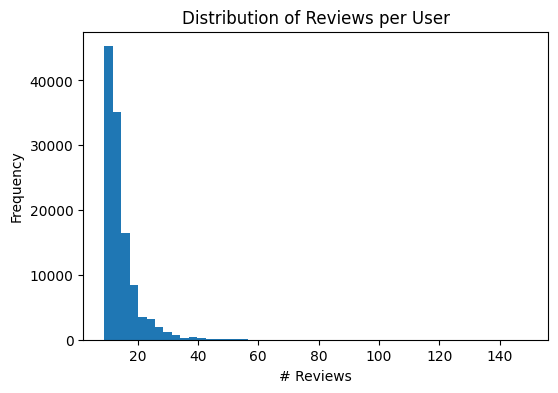

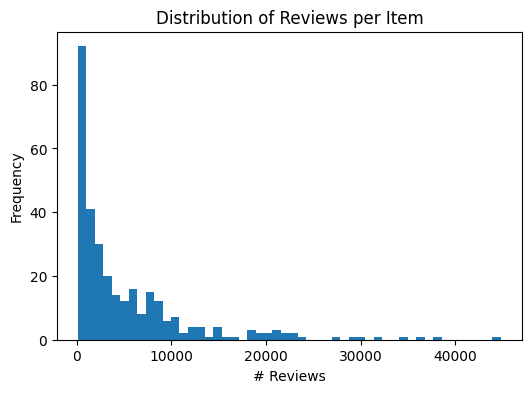

In [9]:
num_users = ratings.user_id.nunique()
num_items = ratings.item_id.nunique()
num_interactions = len(ratings)

sparsity = 1 - (num_interactions / (num_users * num_items))
print(f"Sparsity of the user–item matrix: {sparsity:.4f}")

user_counts = ratings.user_id.value_counts()
plt.figure(figsize=(6,4))
plt.hist(user_counts, bins=50)
plt.title("Distribution of Reviews per User")
plt.xlabel("# Reviews")
plt.ylabel("Frequency")
plt.show()

item_counts = ratings.item_id.value_counts()
plt.figure(figsize=(6,4))
plt.hist(item_counts, bins=50)
plt.title("Distribution of Reviews per Item")
plt.xlabel("# Reviews")
plt.ylabel("Frequency")
plt.show()

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_user_based(user_id, k=10, top_n_users=50):
    if user_id not in train_matrix.index:
        return []

    # Convert to numpy for speed
    target_vector = train_matrix.loc[user_id].values.reshape(1, -1)

    # Compute similarity to all users in batches (no full matrix)
    sims = cosine_similarity(target_vector, train_matrix.values)[0]

    # Get indices of most similar users (excluding self)
    user_indices = np.argsort(sims)[::-1]
    user_indices = user_indices[1:top_n_users+1]

    similar_users = train_matrix.index[user_indices]

    scores = {}

    for neighbor_id in similar_users:
        neighbor_ratings = train_matrix.loc[neighbor_id]

        for item_id, rating in neighbor_ratings.items():
            if rating > 0 and train_matrix.loc[user_id, item_id] == 0:
                scores[item_id] = scores.get(item_id, 0) + 1

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [item for item, _ in ranked[:k]]

print('UBCF recs:', recommend_user_based(sample_user, 5))


UBCF recs: [377160, 72850, 413150, 379720, 620]


In [12]:
def recall_at_k(model_fn, k=10):
    recalls = []
    users = test_df.user_id.unique()
    users = users[:300] if len(users) > 300 else users

    for user in users:
        test_items = test_df[test_df.user_id == user].item_id.tolist()
        if len(test_items) == 0:
            continue

        recs = model_fn(user, k)
        hits = len(set(recs) & set(test_items))
        recalls.append(hits / len(test_items))

    return np.mean(recalls)

print('UBCF Recall@10 (sample):', recall_at_k(recommend_user_based, k=10))

UBCF Recall@10 (sample): 0.32008730158730153


In [30]:
# Load SteamSpy tag dataset
TAG_PATH = "../data/steamspy_tag_data.csv"

tag_df = pd.read_csv(TAG_PATH)

print("Tag dataset loaded:", tag_df.shape)
print(tag_df.head())


Tag dataset loaded: (29022, 372)
   appid  1980s  1990s  2.5d  2d  2d_fighter  360_video  3d  3d_platformer  \
0     10    144    564     0   0           0          0   0              0   
1     20      0     71     0   0           0          0   0              0   
2     30      0      0     0   0           0          0   0              0   
3     40      0      0     0   0           0          0   0              0   
4     50      0     77     0   0           0          0   0              0   

   3d_vision  ...  warhammer_40k  web_publishing  werewolves  western  \
0          0  ...              0               0           0        0   
1          0  ...              0               0           0        0   
2          0  ...              0               0           0        0   
3          0  ...              0               0           0        0   
4          0  ...              0               0           0        0   

   word_game  world_war_i  world_war_ii  wrestling  zombies

In [35]:
# ---- Cell 12: Define Content-Based Recommender ----

# Step 1 — Deduplicate tag file
tag_df = tag_df.drop_duplicates(subset=["item_id", "tag"])

# Step 2 — Only keep items that are in train_matrix
valid_items = set(train_matrix.columns)
tag_df_clean = tag_df[tag_df["item_id"].astype(int).isin(valid_items)].copy()

print("Items in CF:", len(valid_items))
print("Items in CBF (tag file):", tag_df_clean["item_id"].nunique())

# Step 3 — Build item × tag matrix
tag_matrix = (
    tag_df_clean
    .pivot_table(index="item_id",
                 columns="tag",
                 values="value",
                 fill_value=0)
)

print("Tag matrix shape:", tag_matrix.shape)

# Step 4 — Compute item–item cosine similarity
item_sim_cbf = pd.DataFrame(
    cosine_similarity(tag_matrix),
    index=tag_matrix.index,
    columns=tag_matrix.index
)

print("CBF similarity matrix shape:", item_sim_cbf.shape)


# ----- SAFE recommender: never crashes -----
def recommend_cbf_for_user(user_id, top_k=10):

    if user_id not in train_matrix.index:
        return []

    # Items user liked
    user_row = train_matrix.loc[user_id]
    liked_items = user_row[user_row > 0].index.tolist()

    if len(liked_items) == 0:
        return []

    # Keep only liked items that exist in CBF similarity matrix
    liked_items_cbf = [i for i in liked_items if i in item_sim_cbf.index]

    if len(liked_items_cbf) == 0:
        # No tag data available for user’s liked items
        return []

    # Compute mean similarity over valid liked items
    scores = item_sim_cbf.loc[liked_items_cbf].mean(axis=0)

    # Don't recommend items already liked
    scores = scores.drop(liked_items_cbf, errors='ignore')

    # Top-k
    return list(scores.sort_values(ascending=False).head(top_k).index)

KeyError: Index(['tag'], dtype='object')

In [33]:
# --- Safety rebuild for test_matrix ---

# Ensure no duplicate user_id-item_id rows
test_df = test_df.drop_duplicates(subset=['user_id', 'item_id'], keep='first')

if "test_matrix" not in globals():
    print("test_matrix was missing — reconstructing from test_df...")

    test_matrix = (test_df
                   .pivot(index='user_id', columns='item_id', values='rating')
                   .fillna(0)
                   .astype(int))

print("test_matrix shape:", test_matrix.shape)

test_matrix shape: (87860, 313)


In [ ]:
# ---- Cell 13: Evaluate CBF ----

def precision_at_k_cbf(k=10, sample_size=200):
    users = test_matrix.sample(sample_size, random_state=42).index
    precisions = []

    for user_id in users:

        if user_id not in test_matrix.index:
            continue

        # Ground truth
        true_items = test_matrix.loc[user_id]
        true_items = set(true_items[true_items > 0].index)

        if len(true_items) == 0:
            continue

        # Predictions
        preds = recommend_cbf_for_user(user_id, top_k=k)

        if preds is None or len(preds) == 0:
            continue

        # Precision
        hit_count = len([i for i in preds if i in true_items])
        precisions.append(hit_count / k)

    return np.mean(precisions) if len(precisions) > 0 else 0.0


cbf_precision_10 = precision_at_k_cbf()
print("CBF Precision@10:", cbf_precision_10)

## Conclusions & Reproducibility

- This notebook contains implementations and comparisons of multiple recommenders taught in the course: item-item CF, user-user CF, tag-based CBF, and implicit ALS.
- All evaluation is performed offline using Precision@10 and Recall@10.

**Reproducibility notes**:
- Ensure the data files are placed under `./data/` relative to the notebook.
- Install the required packages into your virtual environment:
```
pip install -r requirements.txt
# or at minimum:
pip install pandas numpy scipy scikit-learn matplotlib implicit
```
- If training ALS is slow, reduce `iterations` or `factors` in the ALS call.
